# Text Mining - Análise de Sentimentos dos Reviews da Amazon
### René Porto e Ricardo Rolim

### Importar ficheiros

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from nltk.probability import FreqDist
from textblob import TextBlob

# preciso destas duas linhas
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/a101597/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_train.csv", encoding="utf-8")
df_test = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_test.csv", encoding="utf-8")
df.sample(5)

,sentiment,review
18198,positive,My dog really loves the Stella and Chewy's fre...
7526,positive,My kids enjoy The Cocktail Pepsticks so iI bu...
16411,positive,being a coffee addict for years and being told...
593,positive,I don't know how everyone else got these broke...
45980,positive,"We ordered these for a ""Wedding Chapel"" at a c..."


### Funções

In [3]:
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44

def remover_tag_html(text):
    """
    Function that removes html tags
    Arguments:
        a: text
    Return:
        text without html tags
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [4]:
def stemming(tokens):
    """
    Function that stemms tokens
    Arguments:
        tokens: list of tokens
    Return:
        stemmed words
    """
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [5]:
def summary_dataset(df, df_test):
    """
    Function that returns a summary of a dataset
    Arguments:
        df: train dataset
        df_test: test dataset
    Return:
        summary of train and test dataset
    """
    count_pos_train = df.loc[df.sentiment=='positive', 'sentiment'].count()
    count_neg_train = df.loc[df.sentiment=='negative', 'sentiment'].count()
    count_pos_test = df_test.loc[df_test.sentiment=='positive', 'sentiment'].count()
    count_neg_test = df_test.loc[df_test.sentiment=='negative', 'sentiment'].count()
    total_train = len(df)
    total_test = len(df_test)
    total = total_train + total_test
    print(f"Treino (positivo): {count_pos_train} - {round(100 * count_pos_train / total_train,2)}% \
          \nTreino (negativo): {count_neg_train} - {round(100 * count_neg_train / total_train,2)}% \
          \nTotal Treino: {total_train} - {round(100 * total_train / total,2)}% \
          \n \
          \nTeste (positivo): {count_pos_test} - {round(100 * count_pos_test / total_test,2)}% \
          \nTeste (negativo): {count_neg_test} - {round(100 * count_neg_test / total_test,2)}% \
          \nTotal Teste: {total_test} - {round(100 * total_test / total,2)}% \
          \n \
          \nTotal: {total}")

In [6]:
#https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
#https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

# Decidimos usar o ZERO como review positivo

def sentiment_calc(text):
    """
    Function that returns a binary sentiment calculation using TextBlob
    Arguments:
        text: text
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    try:
        sentiment_binary = TextBlob(text).sentiment.polarity
        return sentiment_binary
    except:
        return None

In [7]:
def sentiment_convert(df, column, convert):
    """
    Function that returns a binary sentiment
    Arguments:
        sentiment: sentiment (positivo ou negativo)
    Return:
        return a binary sentiment number (positivo = 1 ou negativo = 0)
    """
    label = []
    if convert == 0:
        for each in df[column]:
            if each == 'positive':
                label.append(1)
            else:
                label.append(0)
    elif convert == 1:
        for each in df[column]:
            if each == 1:
                label.append('positive')
            else:
                label.append('negative')
    elif convert == 2:
        for each in df[column]:
            if each >= 0:
                label.append('positive')
            else:
                label.append('negative')
    elif convert == 3:
        for each in df[column]:
            if each >= 0:
                label.append(1)
            else:
                label.append(0)
    return label

In [8]:
def create_bag_Word_Corpus(df, column_name, neg):
    """
    Function that creates a bag of words, remove html tags, lower case words, tokenize, 
    remove stop words, stemming, apply negation (optional) and remove punctuation.
    Arguments:
        df: dataframe
        column_name: column to create cleaned bag of words
        neg: create a lexo negation (optinal)
    Return:
        return bag of words
    """
    negation = ["not", "n't"]
    words_corpus  = []
    for val in df[column_name]:
        sk = False
        text = remover_tag_html(val)
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        if neg is True:
            for x, i in enumerate(tokens):
                if i in negation:
                    sk = True
                elif i in string.punctuation:
                    sk = False
                elif sk is True:
                    tokens[x] = "NOT_"+i
        tokens = [word for word in tokens if word not in string.punctuation]
        words_corpus.append(tokens)
    return words_corpus

In [9]:
def sentiment_lex(df, column_name):
    """
    Function that returns a sentiment from a lexo file
    Arguments:
        df: dataframe
        column_name: column to create cleaned bag of words
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    sentiment_lex = []
    for tokens in df[column_name]:
        sentiment_score = sum(lex[x] for x in tokens if x in lex)
        result = 'positive' if sentiment_score >= 0 else 'negative'
        sentiment_lex.append(result)
    return sentiment_lex

In [10]:
#https://medium.com/analytics-vidhya/sentiment-analysis-movies-reviews-b299de4bb1aa

def plot_confusion_matrix_accuracy(df, col_pred, col_actual):
    """
    Function that returns a confusion matrix and accurancy
    Arguments:
        col_pred: column that are inserted our prediction
        col_actual: label
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    cm = confusion_matrix(df[col_pred], df[col_actual], labels=['positive', 'negative'])
    plt.figure(figsize = (5,5))
    sns.heatmap(cm,cmap= "Blues", 
                linecolor = 'black', 
                linewidth = 1, 
                annot = True, 
                fmt='', 
                xticklabels = ['Negative','Positive'], 
                yticklabels = ['Negative','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    score = accuracy_score(df[col_pred], df[col_actual])
    return print("accuracy:   %0.3f" % score)

### Análise Exploratória dos Dados

In [11]:
print(f"Valores de treino duplicados: {df.duplicated().sum()} ")
print(f"Valores de teste duplicados: {df_test.duplicated().sum()} ")

Valores de treino duplicados: 3531 
Valores de teste duplicados: 25 


In [12]:
summary_dataset(df, df_test)

Treino (positivo): 37835 - 77.37%           
Treino (negativo): 11067 - 22.63%           
Total Treino: 48902 - 95.29%           
           
Teste (positivo): 1676 - 69.34%           
Teste (negativo): 741 - 30.66%           
Total Teste: 2417 - 4.71%           
           
Total: 51319


In [13]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
summary_dataset(df, df_test)

Treino (positivo): 35363 - 77.94%           
Treino (negativo): 10008 - 22.06%           
Total Treino: 45371 - 94.99%           
           
Teste (positivo): 1667 - 69.69%           
Teste (negativo): 725 - 30.31%           
Total Teste: 2392 - 5.01%           
           
Total: 47763


Foram encontrados registos duplicados, como a proporção entre os reviews positivos e negativos não se alteraram, decidimos então remover os registos duplicados

### Baseline

In [14]:
df['sentiment_calculated'] = df['review'].apply(sentiment_calc)
df['sentiment_calculated'] = sentiment_convert(df, 'sentiment_calculated', convert=2)

In [15]:
df.sample(10)

,sentiment,review,sentiment_calculated
7785,negative,I ordered this saffron after looking at seller...,negative
25248,positive,"This is for serious HP sauce addicts. I admit,...",positive
9723,positive,This is a great product for people wanting glu...,positive
38965,negative,This product taste strongly of salt substitute...,negative
14342,negative,This was a waste of money! The plastic rope c...,negative
47278,positive,"I can't eat wheat, so this is a life saver for...",positive
17088,positive,I was really hoping to use this as a substitut...,positive
28720,positive,"My son is now one, and looooves these little p...",positive
31156,negative,"Honestly, I feel terrible writing this review ...",negative
18108,positive,"Product speaks for itself, AWESOME!!!!!!!!!! T...",positive


In [16]:
df_test['sentiment_calculated'] = df_test['review'].apply(sentiment_calc)
df_test['sentiment_calculated'] = sentiment_convert(df_test, 'sentiment_calculated', convert=2)

In [17]:
df_test.sample(10)

,sentiment,review,sentiment_calculated
1691,positive,"This is an intense, rich, flavorful coffee. Wh...",positive
375,positive,While I wouldn't call this a health food they ...,positive
518,positive,Perfect mix for me - lots of nuts and dried fr...,positive
504,positive,I love these! I actually don't care for any ot...,positive
1231,positive,My cat loves these. She is very small even tho...,negative
810,positive,I found this product to be a great alternative...,positive
2349,positive,This candy is hard to find in stores nowadays....,positive
1748,negative,I was enticed by the cool design - less trash ...,positive
1617,positive,I am very much enjoying FogChaser. The flavor...,positive
73,negative,"Even my 8 year old, who was super excited to e...",negative


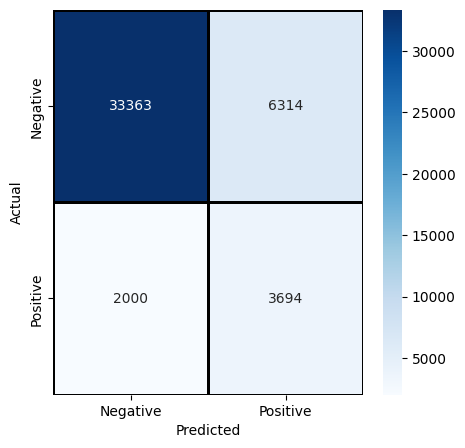

accuracy:   0.817


In [18]:
plot_confusion_matrix_accuracy(df, 'sentiment_calculated', 'sentiment')

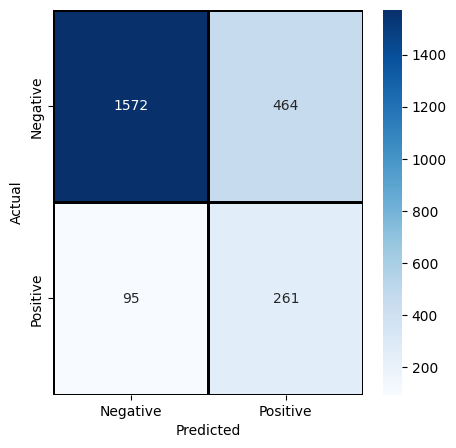

accuracy:   0.766


In [19]:
plot_confusion_matrix_accuracy(df_test, 'sentiment_calculated', 'sentiment')

### Aplicação de um léxico de sentimentos

In [20]:
lex = pd.read_csv("../TM/data/en/NCR-lexicon.csv", encoding="utf-8")
lex.set_index("English", inplace=True)
lex = lex['Positive'] - lex['Negative']
lex = lex.to_dict()

In [21]:
df['bag'] = create_bag_Word_Corpus(df, 'review', neg=False)
df['bag_neg'] = create_bag_Word_Corpus(df, 'review', neg=True)
df['sentiment_lex'] = sentiment_lex(df, 'bag')
df['sentiment_lex_neg'] = sentiment_lex(df, 'bag_neg')

In [22]:
df_test['bag'] = create_bag_Word_Corpus(df_test, 'review', neg=False)
df_test['bag_neg'] = create_bag_Word_Corpus(df_test, 'review', neg=True)
df_test['sentiment_lex'] = sentiment_lex(df_test, 'bag')
df_test['sentiment_lex_neg'] = sentiment_lex(df_test, 'bag_neg')

#### Sem tratamento da negação

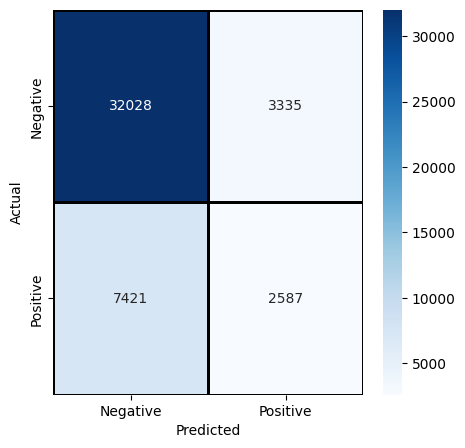

accuracy:   0.763


In [23]:
plot_confusion_matrix_accuracy(df, 'sentiment', 'sentiment_lex')

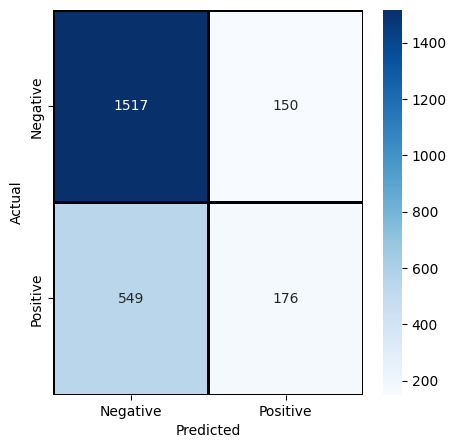

accuracy:   0.708


In [24]:
plot_confusion_matrix_accuracy(df_test, 'sentiment', 'sentiment_lex')

#### Com tratamento da negação

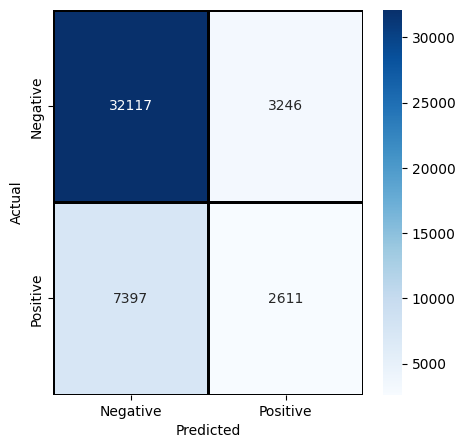

accuracy:   0.765


In [25]:
plot_confusion_matrix_accuracy(df, 'sentiment', 'sentiment_lex_neg')

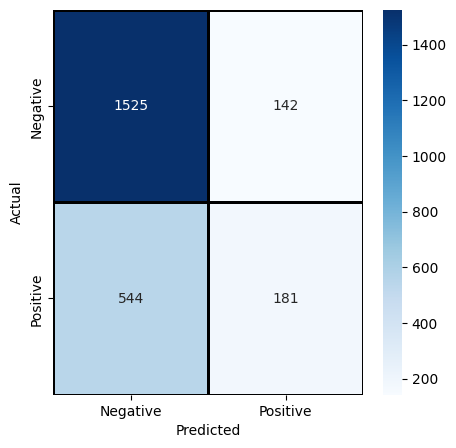

accuracy:   0.713


In [26]:
plot_confusion_matrix_accuracy(df_test, 'sentiment', 'sentiment_lex_neg')

## Aprendizagem automática

### Preparação dos Dados

In [29]:
df['label'] = sentiment_convert(df, 'sentiment', convert=0)
df_test['label'] = sentiment_convert(df_test, 'sentiment', convert=0)

In [30]:
df['review'] = df['review'].apply(str)
df_test['review'] = df_test['review'].apply(str)

### Features

In [31]:
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(df['review'])
test_X = vectorizer.transform(df_test['review'])

In [32]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
train_tfidf = tfidf_vectorizer.fit_transform(df['review']) 
test_tfidf = tfidf_vectorizer.transform(df_test['review']) 

In [33]:
normalized = []
for i in df['bag_neg']:
    colect = ""
    for x in i:
        colect = colect + " " + x
    normalized.append(colect)
    
normalized_test = []
for i in df_test['bag_neg']:
    colect = ""
    for x in i:
        colect = colect + " " + x
    normalized_test.append(colect)
    
vectorizer = CountVectorizer()
train_X_bag = vectorizer.fit_transform(normalized)
test_X_bag = vectorizer.transform(normalized_test)

In [34]:
normalized_tfidf = []
for i in df['bag_neg']:
    colect = ""
    for x in i:
        colect = colect + " " + x
    normalized_tfidf.append(colect)
    
normalized_tfidf_test = []
for i in df_test['bag_neg']:
    colect = ""
    for x in i:
        colect = colect + " " + x
    normalized_tfidf_test.append(colect)
    
tfidf_vectorizer_bag = TfidfVectorizer(use_idf=True)
train_tfidf_bag = tfidf_vectorizer_bag.fit_transform(normalized_tfidf) 
test_tfidf_bag = tfidf_vectorizer_bag.transform(normalized_tfidf_test) 

### Models

#### Multinomial Naive Bayes

In [35]:
name_mnb = "Multinomial Naive Bayes - vectorizer (accuracy): "
nb = MultinomialNB()
Mult_nb = nb.fit(train_X, df['label'])
df_test['sentiment_mnb'] = Mult_nb.predict(test_X)
score_mnb = accuracy_score(df_test['label'], df_test['sentiment_mnb'])
print(f"{name_mnb}   %0.3f" % score_mnb)

Multinomial Naive Bayes - vectorizer (accuracy):    0.855


In [36]:
name_mnb_tfidf = "Multinomial Naive Bayes - TFIDF (accuracy): "
nb = MultinomialNB()
Mult_nb_tfidf = nb.fit(train_tfidf, df['label'])
df_test['sentiment_mnb_tfidf'] = Mult_nb_tfidf.predict(test_tfidf)
score_tfidf_mnb = accuracy_score(df_test['label'], df_test['sentiment_mnb_tfidf'])
print(f"{name_mnb_tfidf}   %0.3f" % score_tfidf_mnb)

Multinomial Naive Bayes - TFIDF (accuracy):    0.709


In [37]:
name_mnb_normalize = "Multinomial Naive Bayes - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
nb = MultinomialNB()
Mult_nb_bag = nb.fit(train_X_bag, df['label'])
df_test['sentiment_mnb_bag'] = Mult_nb_bag.predict(test_X_bag)
score_mnb_bag = accuracy_score(df_test['label'], df_test['sentiment_mnb_bag'])
print(f"{name_mnb_normalize}   %0.3f" % score_mnb_bag)

Multinomial Naive Bayes - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):    0.845


In [38]:
name_mnb_normalize_tdidf = "Multinomial Naive Bayes - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
nb = MultinomialNB()
Mult_nb_tfidf_bag = nb.fit(train_tfidf_bag, df['label'])
df_test['sentiment_mnb_tfidf_bag'] = Mult_nb_tfidf_bag.predict(test_tfidf_bag)
score_tfidf_mnb_bag = accuracy_score(df_test['label'], df_test['sentiment_mnb_tfidf_bag'])
print(f"{name_mnb_normalize_tdidf}    %0.3f" % score_tfidf_mnb_bag)

Multinomial Naive Bayes - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.716


#### Logistic regression

In [39]:
name_lr = "Logistic regression - vectorizer (accuracy): "
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lre = lr.fit(train_X, df['label'])
df_test['sentiment_lr'] = lre.predict(test_X)
score_lre = accuracy_score(df_test['label'], df_test['sentiment_lr'])
print(f"{name_lr}    %0.3f" % score_lre)

Logistic regression - vectorizer (accuracy):     0.866


In [40]:
name_lr_tfidf = "Logistic regression - TFIDF (accuracy): "
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lre_tfidf = lr.fit(train_tfidf, df['label'])
df_test['sentiment_lr_tfidf'] = lre_tfidf.predict(test_tfidf)
score_tfidf_lre = accuracy_score(df_test['label'], df_test['sentiment_lr_tfidf'])
print(f"{name_lr_tfidf}    %0.3f" % score_tfidf_lre)

Logistic regression - TFIDF (accuracy):     0.855


In [41]:
name_lr_normalize = "Logistic regression - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
Mult_lr_bag = lr.fit(train_X_bag, df['label'])
df_test['sentiment_lr_bag'] = Mult_lr_bag.predict(test_X_bag)
score_lr_bag = accuracy_score(df_test['label'], df_test['sentiment_lr_bag'])
print(f"{name_lr_normalize}    %0.3f" % score_lr_bag)

Logistic regression - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.856


In [43]:
name_lr_normalize_tdidf = "Logistic regression - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
Mult_lr_tfidf_bag = nb.fit(train_tfidf_bag, df['label'])
df_test['sentiment_lr_tfidf_bag'] = Mult_lr_tfidf_bag.predict(test_tfidf_bag)
score_tfidf_lr_bag = accuracy_score(df_test['label'], df_test['sentiment_lr_tfidf_bag'])
print(f"{name_lr_normalize_tdidf}    %0.3f" % score_tfidf_lr_bag)

Logistic regression - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.716


#### Linear SVC

In [44]:
name_svmc = "Linear SVC - vectorizer (accuracy): "
svmc = LinearSVC(max_iter=20000)
lsvm = svmc.fit(train_X, df['label'])
df_test['sentiment_lsvm'] = lsvm.predict(test_X)
score_lsvm = accuracy_score(df_test['label'], df_test['sentiment_lsvm'])
print(f"{name_svmc}    %0.3f" % score_lsvm)

Linear SVC - vectorizer (accuracy):     0.840


In [45]:
name_svmc_tfidf = "Linear SVC - TFIDF (accuracy): "
svmc = LinearSVC(max_iter=20000)
lsvm_tfidf = svmc.fit(train_tfidf, df['label'])
df_test['sentiment_lsvm_tfidf'] = lsvm_tfidf.predict(test_tfidf)
score_tfidf_lsvm = accuracy_score(df_test['label'], df_test['sentiment_lsvm_tfidf'])
print(f"{name_svmc_tfidf}    %0.3f" % score_tfidf_lsvm)

Linear SVC - TFIDF (accuracy):     0.868


In [46]:
name_svmc_normalize = "Linear SVC - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
svmc = LinearSVC(max_iter=20000)
Mult_svmc_bag = svmc.fit(train_X_bag, df['label'])
df_test['sentiment_svmc_bag'] = Mult_svmc_bag.predict(test_X_bag)
score_svmc_bag = accuracy_score(df_test['label'], df_test['sentiment_svmc_bag'])
print(f"{name_svmc_normalize}    %0.3f" % score_svmc_bag)

Linear SVC - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.840


In [47]:
name_svmc_normalize_tdidf = "Linear SVC - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy): "
svmc = LinearSVC(max_iter=20000)
Mult_svmc_tfidf_bag = svmc.fit(train_tfidf_bag, df['label'])
df_test['sentiment_svmc_tfidf_bag'] = Mult_svmc_tfidf_bag.predict(test_tfidf_bag)
score_tfidf_svmc_bag = accuracy_score(df_test['label'], df_test['sentiment_svmc_tfidf_bag'])
print(f"{name_svmc_normalize_tdidf}    %0.3f" % score_tfidf_svmc_bag)

Linear SVC - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.861


### Pipeline

In [48]:
df = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_train.csv", encoding="utf-8")
df_test = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_test.csv", encoding="utf-8")

df_sample = df
df_sample_test = df_test

df_sample['sentiment'] = sentiment_convert(df_sample, 'sentiment', convert=0)
df_sample_test['sentiment'] = sentiment_convert(df_sample_test, 'sentiment', convert=0)

df_sample["label"] = df["sentiment"]
df_sample_test["label"] = df_sample_test["sentiment"]

df_sample["review"] = df["review"].apply(str)
df_sample_test["review"] = df_sample_test["review"].apply(str)

X_train_pipe, y_train_pipe = df_sample["review"], df_sample["label"]
X_test_pipe, y_test_pipe = df_sample_test["review"], df_sample_test["label"]

In [49]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__penalty': ('l1', 'l2')
}

In [50]:
text_clf.fit(X_train_pipe, y_train_pipe)
predicted_pipe = text_clf.predict(X_test_pipe)

In [51]:
score_pipeline_svmc_bag = accuracy_score(df_test['label'], predicted_pipe)
print("Pipeline - Linear SVC accuracy:   %0.3f" % score_pipeline_svmc_bag)

Pipeline - Linear SVC accuracy:   0.867


In [52]:
print(metrics.classification_report(y_test_pipe, predicted_pipe, target_names=['positive', 'negative']))
metrics.confusion_matrix(y_test_pipe, predicted_pipe)

              precision    recall  f1-score   support

    positive       0.83      0.72      0.77       741
    negative       0.88      0.93      0.91      1676

    accuracy                           0.87      2417
   macro avg       0.85      0.83      0.84      2417
weighted avg       0.86      0.87      0.86      2417



array([[ 533,  208],
       [ 113, 1563]])

In [53]:
#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
#https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

text_clf2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__fit_prior': (True, False)
}

In [54]:
text_clf2.fit(X_train_pipe, y_train_pipe)
predicted_pipe2 = text_clf2.predict(X_test_pipe)

In [55]:
score_pipeline_mnb_bag = accuracy_score(df_test['label'], predicted_pipe2)
print("Pipeline-MultinomialNB accuracy:   %0.3f" % score_pipeline_mnb_bag)

Pipeline-MultinomialNB accuracy:   0.710


In [56]:
print(metrics.classification_report(y_test_pipe, predicted_pipe2, target_names=['positive', 'negative']))
metrics.confusion_matrix(y_test_pipe, predicted_pipe2)

              precision    recall  f1-score   support

    positive       0.91      0.06      0.11       741
    negative       0.71      1.00      0.83      1676

    accuracy                           0.71      2417
   macro avg       0.81      0.53      0.47      2417
weighted avg       0.77      0.71      0.61      2417



array([[  43,  698],
       [   4, 1672]])

## Tabela Final

In [57]:
print(f"{name_mnb}   %0.3f" % score_mnb)
print(f"{name_mnb_tfidf}   %0.3f" % score_tfidf_mnb)
print(f"{name_mnb_normalize}   %0.3f" % score_mnb_bag)
print(f"{name_mnb_normalize_tdidf}    %0.3f" % score_tfidf_mnb_bag)

print(f"{name_lr}    %0.3f" % score_lre)
print(f"{name_lr_tfidf}    %0.3f" % score_tfidf_lre)
print(f"{name_lr_normalize}    %0.3f" % score_lr_bag)
print(f"{name_lr_normalize_tdidf}    %0.3f" % score_tfidf_lr_bag)

print(f"{name_svmc}    %0.3f" % score_lsvm)
print(f"{name_svmc_tfidf}    %0.3f" % score_tfidf_lsvm)
print(f"{name_svmc_normalize}    %0.3f" % score_svmc_bag)
print(f"{name_svmc_normalize_tdidf}    %0.3f" % score_tfidf_svmc_bag)

print("Pipeline - Linear SVC accuracy:   %0.3f" % score_pipeline_svmc_bag)
print("Pipeline-MultinomialNB accuracy:   %0.3f" % score_pipeline_mnb_bag)

Multinomial Naive Bayes - vectorizer (accuracy):    0.855
Multinomial Naive Bayes - TFIDF (accuracy):    0.709
Multinomial Naive Bayes - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):    0.845
Multinomial Naive Bayes - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.716
Logistic regression - vectorizer (accuracy):     0.866
Logistic regression - TFIDF (accuracy):     0.855
Logistic regression - vectorizer, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.856
Logistic regression - TFIDF, retirar tags HTML, lowercase, tokenize, stopwords, stemming, tratamento de negação e retirar pontuação  (accuracy):     0.716
Linear SVC - vectorizer (accuracy):     0.840
Linear SVC - TFIDF (accuracy):     0.868
Linear SVC - vectorizer, retirar tags HTML, lowercase, token